In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd

from timeit import default_timer as timer
import random

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

import json
import pickle
import os
import sys
sys.path.append("../python/")
from helpers import *
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [2]:
# Globals
NUM_CHANNELS = 3
IMAGE_WIDTH_LIST = [189]#, 252, 336]
SCENARIO_LIST = ["Pr_Po_Im"] #, PrPo_Im "Pr_Im", "Pr_PoIm", "Pr_Po_Im"]
NUM_EPOCHS = 20
SAVED_MODEL_DIR = '../../results/models/'
MODEL_PERFORMANCE_METRICS_DIR = '../../results/model-performance/'

In [3]:
# Load image sets
IMAGE_SETS_SQUARE_TRAIN = createResolutionScenarioImageDict(IMAGE_WIDTH_LIST, SCENARIO_LIST, train=True, rectangular = False)
IMAGE_SETS_SQUARE_TEST = createResolutionScenarioImageDict(IMAGE_WIDTH_LIST, SCENARIO_LIST, train=False, rectangular = False)
IMAGE_SETS_RECT_TRAIN = createResolutionScenarioImageDict(IMAGE_WIDTH_LIST, SCENARIO_LIST, train=True, rectangular = True)
IMAGE_SETS_RECT_TEST = createResolutionScenarioImageDict(IMAGE_WIDTH_LIST, SCENARIO_LIST, train=False, rectangular = True)

In [4]:
class Metrics(Callback):
    def __init__(self, val_data):#, batch_size = 64):
        super().__init__()
        self.validation_data = val_data

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        xVal, yVal = self.validation_data
        val_pred = np.argmax(np.asarray(self.model.predict(xVal)), axis=1)
        val_true = np.argmax(yVal, axis=1)        
        _val_f1 = f1_score(val_true, val_pred, average='macro', zero_division = 0)
        _val_precision = precision_score(val_true, val_pred, average='macro', zero_division = 0)
        _val_recall = recall_score(val_true, val_pred, average='macro', zero_division = 0)

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        logs["val_f1"] = _val_f1
        logs["val_recall"] = _val_recall
        logs["val_precision"] = _val_precision
        print('— val_f1: %f — val_precision: %f — val_recall %f' %(_val_f1, _val_precision, _val_recall))
        return

In [5]:
def testCNN(image_width, image_height, num_channels=3):
    image_shape = (image_width, image_height, num_channels)
    print('Image shape: ', image_shape)
    model = models.Sequential()

    model.add(layers.Conv2D(filters = 64, kernel_size = 5, strides = 2, activation="relu", padding="same", 
        input_shape = image_shape ))

    model.add(layers.MaxPooling2D(2))
    model.add(layers.Conv2D(128, 3, activation="relu", padding="same"))
    model.add(layers.Conv2D(128, 3, activation="relu", padding="same"))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Conv2D(256, 3, activation="relu", padding="same"))
    model.add(layers.Conv2D(256, 3, activation="relu", padding="same"))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Flatten())

    model.add(layers.Dense(units = 408, activation = 'relu'))
    model.add(layers.BatchNormalization()) # Networks train faster & converge much more quickly
    model.add(layers.Dropout(.3))

    model.add(layers.Dense(units = 408, activation = 'relu'))
    model.add(layers.Dropout(.3))

    model.add(layers.Dense(3, activation='softmax'))

    # Choose an optimal value from 0.01, 0.001, or 0.0001
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = .001), #learning_rate = hp_learning_rate not defined
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
    return(model)

In [6]:
def trainModelWithDetailedMetrics(image_width, scenario, num_epochs = 10, trial_seed = 1, rectangular = True, testing = True): 
    # IMAGES (former approach)
    # training_images_and_labels, test_images_and_labels = splitData(image_sets[image_size][scenario], prop = 0.8, seed_num = trial_seed)
    # training_images, training_labels = getImageAndLabelArrays(training_images_and_labels)
    # test_images, test_labels = getImageAndLabelArrays(test_images_and_labels)
    if rectangular:
        image_height = getRectangularImageHeight(image_width)
    else:
        image_height = image_width

    class_labels = getClassLabels(scenario)
    print("Class labels:", class_labels)

    if rectangular==True:
        image_dictionary_train = IMAGE_SETS_RECT_TRAIN
        image_dictionary_test = IMAGE_SETS_RECT_TEST
    else:
        image_dictionary_train = IMAGE_SETS_SQUARE_TRAIN
        image_dictionary_test = IMAGE_SETS_SQUARE_TEST

        
    training_images = np.array([x[0] for x in image_dictionary_train[image_width][scenario]]) ## TOD)
    training_labels = np.array([x[1] for x in image_dictionary_train[image_width][scenario]]) 
    test_images = np.array([x[0] for x in image_dictionary_test[image_width][scenario]]) ## TOD)
    test_labels = np.array([x[1] for x in image_dictionary_test[image_width][scenario]]) 
#     training_images = np.array([np.expand_dims(x[0],axis=2) for x in image_dictionary_train[image_width][scenario]]) ## TOD)
#     training_labels = np.array([x[1] for x in image_dictionary_train[image_width][scenario]]) 
#     test_images = np.array([np.expand_dims(x[0],axis=2) for x in image_dictionary_test[image_width][scenario]]) ## TOD)
#     test_labels = np.array([x[1] for x in image_dictionary_test[image_width][scenario]]) 

    print("Number of class training images:", training_labels.sum(axis=0), "total: ", training_labels.sum())
    print("Number of class test images:", test_labels.sum(axis=0), "total: ", test_labels.sum())
    
    # CALLBACKS
    model_metrics = Metrics(val_data=(test_images, test_labels))
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
    
    # INIT MODEL AND PARAMS, FIT
    K.clear_session()
    #input_shape = (image_size, image_size, NUM_CHANNELS) ## shape of images
    if testing:
        model = testCNN(image_width, image_height, num_channels=NUM_CHANNELS)
    else:
        model = constructOptBaseCNN(image_width, image_height, scenario, num_channels = NUM_CHANNELS)    ## get model
        opt_learning_rate = getOptCNNHyperparams(image_width, image_height, scenario)['learning_rate']    ## learning rate
        opt = tf.keras.optimizers.Adam(learning_rate = opt_learning_rate)    
    reset_weights(model) # re-initialize model weights
    if testing:
        model.compile(loss='categorical_crossentropy', metrics =  ['accuracy'])     ## compile and fit
    else:
        model.compile(loss='categorical_crossentropy', optimizer = opt, metrics =  ['accuracy'])     ## compile and fit
    hist = model.fit(training_images, training_labels, batch_size = 32, epochs = num_epochs, verbose=1, 
                     validation_data=(test_images, test_labels),
                     callbacks = [model_metrics]) #, early_stopping])     
    
    # SAVE MODEL, SUMMARY AND PERFORMANCE
    if testing == True:
        model_name = "test-opt-cnn-" + scenario + "-w-" + str(image_width) + "-px-h-" + str(image_height) + "-px"
    else:
        model_name = "opt-cnn-" + scenario + "-w-" +str(image_width) + "-px-h-" + str(image_height) + "-px"
    model_folder = "model"
    if not os.path.exists(SAVED_MODEL_DIR):  
        os.makedirs(SAVED_MODEL_DIR)
    model.save(os.path.join(SAVED_MODEL_DIR, model_name, model_folder))     ## Save model summary
    #print(os.path.join(SAVED_MODEL_DIR, model_name, "summary.txt"))
    with open(os.path.join(SAVED_MODEL_DIR, model_name, "summary.txt"), 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))
    with open(os.path.join(SAVED_MODEL_DIR, model_name, "history.txt"), 'w') as f:
        f.write(json.dumps(hist.history))    
   
    # ANALYZE PERFORMANCE AND SAVE OUTPUTS
    y_pred = np.argmax(model.predict(test_images), axis=-1)     ## Params
    ## Classification report
    report = classification_report(np.argmax(test_labels, axis=-1), y_pred, zero_division=0,
                                   labels = np.arange(len(class_labels)), target_names=class_labels, output_dict=True)
    print("Classification report for scenario " + scenario + ", width: " + str(image_width) + ", height: " + str(image_height) + ":")
    report = pd.DataFrame(report).transpose().round(2)
    if not os.path.exists('../../results/classification-reports/'):  
        os.makedirs('../../results/classification-reports/')
    classification_report_suffix = scenario + "-w-" + str(image_width) + "-h-" + str(image_height) + "px.csv"
    if testing == True:
        report.to_csv("../../results/classification-reports/test-opt-classification-report-" + classification_report_suffix)
    else:
        report.to_csv("../../results/classification-reports/opt-classification-report-" + classification_report_suffix)        
    print(report)
    
    ## Confusion matrix
    con_mat = tf.math.confusion_matrix(labels=np.argmax(test_labels, axis=-1), predictions=y_pred).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(con_mat_norm, index = class_labels, columns = class_labels)
    #print("Confusion matrix for scenario " + scenario + ", resolution: " + str(image_size) + ":")
    #print(con_mat_df)
    figure = plt.figure()#figsize=(4, 4))    ## Confusion matrix heatmap
    ax = sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues, fmt='g', cbar = False, annot_kws={"size": 16})
    #figure.tight_layout()
    plt.ylabel('True',fontsize=16)
    ax.set_yticklabels(class_labels,va='center',fontsize=14)
    ax.set_xticklabels(class_labels, ha='center',fontsize=14)
    plt.xlabel('Predicted',fontsize=16)
    #plt.show()
    file_suffix =  scenario + "-w-" + str(image_width) + "-px-h-" + str(image_height) + "-px.png"
    if testing == True:
        con_mat_heatmap_file = "../../figures/test-opt-confusion-matrix-" +  file_suffix
    else:
        con_mat_heatmap_file = "../../figures/opt-confusion-matrix-" +  file_suffix
    figure.savefig(con_mat_heatmap_file, dpi=180)#, bbox_inches='tight')
    return(model, hist) 

In [7]:
def getScenarioModelPerformance(width = 189, num_epochs = 15, seed_val = 1, rect_boolean = True, test_boolean = True):
    df = pd.DataFrame()
    if rect_boolean:
        height = getRectangularImageHeight(width)
    else:
        height = width
    for s in SCENARIO_LIST:
        m, h = trainModelWithDetailedMetrics(width, s, num_epochs, trial_seed = seed_val, 
            rectangular = rect_boolean, testing = test_boolean)
        #visualizeCNN(m, s, width, images_per_class = 4, trial_seed = seed_val, testing = test_boolean)       
        perf = pd.DataFrame.from_dict(h.history)
        perf[['Scenario']] = s
        perf['epoch'] = perf.index + 1
        df = df.append(perf, ignore_index=True)
        #del m
    if test_boolean == True:
        df_filename = "../../results/test-opt-cnn-performance-metrics-summary-w-" + str(width) + "-px-h" + str(height) + "-px.csv"
    else:
        df_filename = "../../results/opt-cnn-performance-metrics-summary-w-" + str(width) + "-px-h" + str(height) +  "-px.csv"
    df.to_csv(df_filename)
    return df

Class labels: ['Improbable', 'Possible', 'Probable']
Number of class training images: [740 208 116] total:  1064
Number of class test images: [89 26 18] total:  133
Image shape:  (189, 189, 3)
34/34 [==============================] - 28s 788ms/step - loss: 1.1699 - accuracy: 0.5565 - val_loss: 8.3061 - val_accuracy: 0.6692
— val_f1: 0.267267 — val_precision: 0.223058 — val_recall 0.333333
INFO:tensorflow:Assets written to: ../../results/models/test-opt-cnn-Pr_Po_Im-w-189-px-h-189-px\model\assets
Classification report for scenario Pr_Po_Im, width: 189, height: 189:
              precision  recall  f1-score  support
Improbable         0.67    1.00      0.80    89.00
Possible           0.00    0.00      0.00    26.00
Probable           0.00    0.00      0.00    18.00
accuracy           0.67    0.67      0.67     0.67
macro avg          0.22    0.33      0.27   133.00
weighted avg       0.45    0.67      0.54   133.00


KeyError: "None of [Index(['Scenario'], dtype='object')] are in the [columns]"

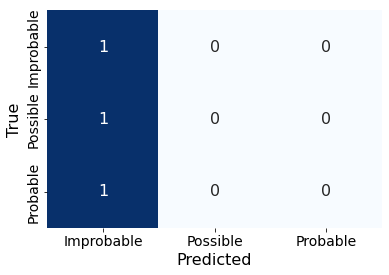

In [8]:
getScenarioModelPerformance(width=189, num_epochs=1, seed_val = 2, rect_boolean = False, test_boolean=True)